In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

#------------------------------------------------------------------------------------------------------------------
df = pd.read_csv("data/run0113_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
meanpeak = 0.034453705499999994
AoE = df[df.columns[1]]#/meanpeak


#-------------------------------------------------------
A , B, w = 105, 135, 30           #start - end - energy window #IC(205, 235, 30 )
n = 500
binw = 0.001    #bin width 0.008 , 0.0045, 0.002
#------------------------------- --------------------------------------------------------------- Models
def gauss(x, amp, center, sigma):
    return amp/(np.sqrt(2*np.pi))/sigma*(np.exp(-0.5*((x-center)/sigma)**2))
def tail(x, m, f, l, d, t):
    return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
def fexpo(x, f, a):
    return exp(f * x + a)
def totalfit(x, ampl, mu, std, m, f, l, t, ampl2, mu2, std2):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t) + gauss(x, ampl2, mu2, std2)
def totalfit_old(x, ampl, mu, std, m, f, l, t):
    return gauss(x, ampl, mu, std) + tail(x, m, f, l, 0, t)
#--------------------------------------------------------------------------------------------- Figure settings
fig, axs = plt.subplots(6,5, figsize=(10,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot_old = []
meanstot_new = []
stds  =  []
stdtot_old = []
stdtot_new = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(30):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
#-------------------------------------------------------
#------------------------------------------------------- bins and centroid
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,x,_= axs[j].hist(xdata, \
                       bins = b, \
                       histtype=u'step', density=True, alpha=0.5, color='orange', \
                       label='%.f to %.f keV' %(A, B))

    x = (x[1:]+x[:-1])/2    
    centroid = x[np.argmax(y)]
    centroid_list.append(centroid)
#-------------------------------------------------------
    
#------------------------------------------------------- Gaussian model        
    model1 = Model(gauss, prefix='g_')
    paramslm = model1.make_params(g_amp=len(xdata), g_center=centroid, g_sigma=centroid*0.01)
    paramslm['g_amp'].min = 0.
    paramslm['g_center'].min = centroid * 0.9
    paramslm['g_center'].max = centroid * 1.1
    paramslm['g_sigma'].min = 0
    paramslm['g_sigma'].max = 1
    
    result1 = model1.fit(y[(x>centroid*0.985) & (x<centroid*1.2)], paramslm, x=x[(x>centroid*0.985) & (x<centroid*1.2)])
    means.append(result1.params['g_center'].value)
    stds.append(result1.params['g_sigma'].value)
    xticks.append(A)

#-------------------------------------------------------EXTRAMODEL
    model4 = Model(gauss, prefix='e_')
    paramslm4 = model4.make_params(e_amp=len(xdata), e_center=centroid*0.6, e_sigma=centroid*0.01)
    paramslm4['e_amp'].min = 0.
    paramslm4['e_center'].min = centroid * 0.5
    paramslm4['e_center'].max = centroid * 0.9
    paramslm4['e_sigma'].min = 0
    paramslm4['e_sigma'].max = 1
    
    result4 = model4.fit(y[(x>centroid*0.1) & (x<centroid*0.9)], paramslm4, x=x[(x>centroid*0.1) & (x<centroid*0.9)])

#------------------------------------------------------- Expo
    model3 = Model(fexpo, prefix='e_') 
    paramslmex = model3.make_params(e_f=1, e_a=1)
    
    expo_min = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    expo_max = result1.params['g_center'].value - 4*result1.params['g_sigma'].value
    
    fmin = result1.params['g_center'].value - 25*result1.params['g_sigma'].value
    fmax = result1.params['g_center'].value + 10*result1.params['g_sigma'].value

    result3 = model3.fit(y[x>fmin], paramslmex, x=x[x>fmin])    
#-------------------------------------------------------

#------------------------------------------------------- The tail(from direct model)
    enteries = 0
    for i in range(len(xdata)):
        if (xdata[i] < result1.params['g_center'].value  - 3*result1.params['g_sigma'].value) & \
        (xdata[i] > result1.params['g_center'].value  - 25*result1.params['g_sigma'].value):
            enteries = enteries +1
    model2 = Model(tail, prefix='t_') 
    paramslm2 = model2.make_params(t_m= enteries * result1.params['g_center'].value, \
                              t_f= result3.params['e_f'].value, \
                              t_l= result1.params['g_center'].value - 1.2 * result1.params['g_sigma'].value, \
                              t_d= 0 ,\
                              t_t= 0.2 * result1.params['g_sigma'].value )
    paramslm2['t_d'].vary = False
    
    min_tail = result1.params['g_center'].value - 25 * result1.params['g_sigma'].value
    max_tail = result1.params['g_center'].value + 10 * result1.params['g_sigma'].value
    
    result2 = model2.fit(y[(x>min_tail) & (x<max_tail)], paramslm2, x=x[(x>min_tail) & (x<max_tail)])
#-------------------------------------------------------
    
    modeltot = Model(totalfit, prefix='tot_') 
    paramstot = modeltot.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value, \
                                     tot_ampl2=result4.params['e_amp'].value, \
                                     tot_mu2=result4.params['e_center'].value, \
                                     tot_std2=result4.params['e_sigma'].value)
    
    paramstot['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot['tot_m'].min  = 0
    paramstot['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot['tot_t'].min  = 0
    paramstot['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot = modeltot.fit(y, paramstot, x=x)#, weights=weight)
    chi.append(resulttot.redchi)
    
    #------------------------
    modeltot_old = Model(totalfit_old, prefix='tot_') 
    paramstot_old = modeltot_old.make_params(tot_ampl=result1.params['g_amp'].value, \
                                     tot_mu = result1.params['g_center'].value, \
                                     tot_std = result1.params['g_sigma'].value, \
                                     tot_m = result2.params['t_m'].value, \
                                     tot_f = result2.params['t_f'].value, \
                                     tot_l = result2.params['t_l'].value, \
                                     tot_t = result2.params['t_t'].value)
    
    paramstot_old['tot_ampl'].min  = 0.95 * result1.params['g_amp'].value
    paramstot_old['tot_ampl'].max  = 1.05 * result1.params['g_amp'].value

    paramstot_old['tot_mu'].min  = 0.995 * result1.params['g_center'].value
    paramstot_old['tot_mu'].max  = 1.005 * result1.params['g_center'].value
    
    paramstot_old['tot_std'].min  = 0.98 * result1.params['g_sigma'].value
    paramstot_old['tot_std'].max  = 1.02 * result1.params['g_sigma'].value
    
    paramstot_old['tot_m'].min  = 0
    paramstot_old['tot_m'].max  = 10 * result2.params['t_m'].value
    
    paramstot_old['tot_f'].min  = 0.2 * result2.params['t_f'].value
    paramstot_old['tot_f'].max  = 5.0 * result2.params['t_f'].value
    
    paramstot_old['tot_l'].min  = 0.5 * result2.params['t_l'].value
    paramstot_old['tot_l'].max  = 2.0 * result2.params['t_l'].value
    
    paramstot_old['tot_t'].min  = 0
    paramstot_old['tot_t'].max  = 2.0 * result1.params['g_sigma'].value
    
    #resulttot = modeltot.fit(y, paramstot, x=x, weights=np.sqrt(1.0/np.std(AoE)))
    weight = 1/np.std(xdata)
    resulttot_old = modeltot_old.fit(y, paramstot_old, x=x)#, weights=weight)
    
    meanstot_new.append(resulttot.params['tot_mu'].value)
    meanstot_old.append(resulttot_old.params['tot_mu'].value)
    
    stdtot_new.append(resulttot.params['tot_std'].value)
    stdtot_old.append(resulttot_old.params['tot_std'].value)
    
    #------------------------------------------------------- Total fit
    SSE = gauss(x, resulttot.params['tot_ampl'].value, resulttot.params['tot_mu'].value, resulttot.params['tot_std'].value)
    MSE = tail(x, resulttot.params['tot_m'].value, resulttot.params['tot_f'].value, \
               resulttot.params['tot_l'].value, 0, resulttot.params['tot_t'].value)
    plateau = gauss(x[(x>centroid*0.1) & (x<centroid*0.9)], result4.params['e_amp'].value, result4.params['e_center'].value, result4.params['e_sigma'].value)
#-------------------------------------------------------
#------------------------------------------------------- Plotting
#     axs[j].plot(x, SSE, color='r', lw=0.5)
#     axs[j].plot(x, MSE, color='b', lw=0.5)
#     axs[j].plot(x[(x>centroid*0.1) & (x<centroid*0.9)], plateau, color='violet', lw=0.5, label='Extra gaussian')
    axs[j].plot(x, resulttot_old.best_fit, color='b', lw=1, label='Old model')
    axs[j].plot(x, resulttot.best_fit, color='r', lw=1, label='New model')
    axs[j].legend(loc=2, prop={'size': 7})
    axs[j].set_xlim(0.01,0.05)
    #axs[j].set_xlim(0.02,0.06)
    axs[j].set_xticks([0.01,0.05])
    A = A + w
    B = B + w
    
plt.close()    

print(B)
print("New", meanstot_new)
print("old", meanstot_old)

<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow encountered in exp
  return m * (np.exp(f*(x-l)+d)) / (np.exp((x-l)/t)+1)
<ipython-input-4-955a89bb2fbc>:27: RuntimeWarning: overflow en

1035
New [0.03369785812515315, 0.03490077454294428, 0.034712409115721966, 0.034836794523853666, 0.03465906583989118, 0.03473661384560417, 0.03455327550117776, 0.03463312702261238, 0.0348011682902564, 0.03466119602996812, 0.03478136823015023, 0.034554889724401384, 0.03474110295066182, 0.03467564996345512, 0.034678809803600746, 0.0346133553028532, 0.03478202138380029, 0.034734438604935525, 0.03472814324759212, 0.03465412454273887, 0.03458192455277727, 0.03500788421784907, 0.03466361784360355, 0.03491283131000732, 0.03477056145909047, 0.03469671567120618, 0.03483783801454078, 0.03376087172820974, 0.034746627614294395, 0.03476000660653279]
old [0.03369785812515315, 0.035238392956004165, 0.034897500965149646, 0.034836794523853666, 0.03465906583989118, 0.03491174942426159, 0.03455327550117776, 0.0346331880141911, 0.03461583206287427, 0.03466119602996812, 0.03464531262290449, 0.03455488972440138, 0.03474110295066182, 0.034487564205680526, 0.034678809803600746, 0.03441026627579019, 0.034711164

[-4.23672228e-09  3.46580622e-02]
[9.6289262e-08 3.4610506e-02]
30


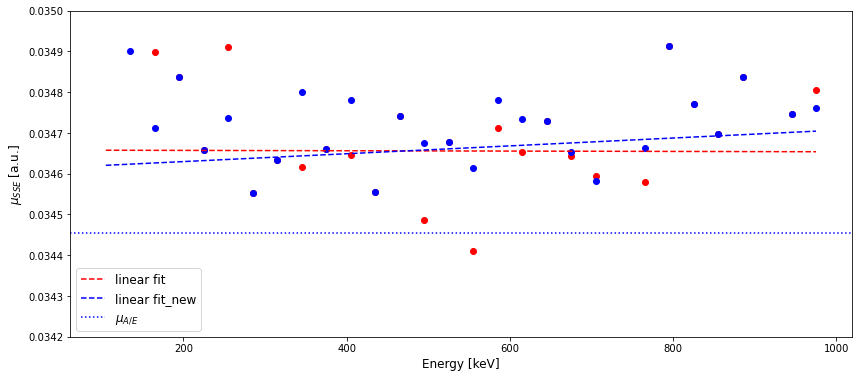

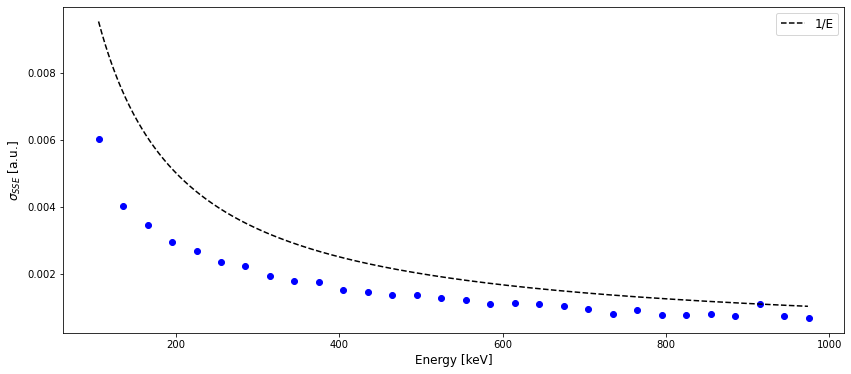

In [5]:
fig = plt.figure(figsize=(14,6))
coef = np.polyfit(xticks,meanstot_old,1)
coef2 = np.polyfit(xticks,meanstot_new,1)

poly1d_fn = np.poly1d(coef) 
poly1d_fn2 = np.poly1d(coef2) 

plt.scatter(xticks,meanstot_old, marker='o',  color='red')
plt.scatter(xticks,meanstot_new, marker='o',  color='blue' )

plt.plot(xticks, poly1d_fn(xticks), '--r', label='linear fit')
plt.plot(xticks, poly1d_fn2(xticks), '--b', label='linear fit_new')

plt.ylim(min(meanstot_old),max(meanstot_old))
plt.ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.ylim(0.0342,0.035)
# plt.xticks(np.arange(100,1200,100))
# plt.xlim(305,800)
plt.axhline(0.034453705499999994, linestyle=':', color='b', label='$\u03BC_{A/E}$')
#plt.axhline(0.04440362125000001, linestyle=':', color='r', label='$\u03BC_{A/E}$')
plt.legend(prop={'size': 12})


# plt.savefig('new_plots/BEGmean(run113)(205_to_%.f).pdf'%(w))

print(coef)
print(coef2)
#print(binw, '-----', n)
print(len(stdtot_new))

stdtot_old =  [abs(ele) for ele in stdtot_old]
# stdtot_new =  [abs(ele) for ele in stdtot_new]

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks, stdtot_old, marker='o', color='b')
# plt.scatter(xticks, stdtot_new, marker='o', color='red') 
E = np.arange(min(xticks), max(xticks), 1)
ss = 1/E 
plt.plot(E,ss, color='k', linestyle='--', label = '1/E')
plt.ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
# plt.xticks(np.arange(100,1200,100))
# plt.xlim(305,800)
plt.legend(prop={'size': 12})

# #plt.savefig('plots/ICsigma(run113)(115)(%.2e)(%.f).pdf'%(coef[0],w))

# #binw = 0.0001, 0.0007

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import stats
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, ConstantModel
from lmfit import Model

A, B, w = 115, 145, 30
binw = 0.0001        #0.00045

x0, sigma = 0, 0.1

# Function to be fitted
def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)
df = pd.read_csv("data/run0115_git_det37_tier3_table.txt", sep=" ", header=0)
df.head()
l = len(df)
energy = df[df.columns[0]]
AoE = df[df.columns[1]]

#--------------------------------------------------------------------------------------------- 30 keV
#--------------------------------------------------------------------------------------------- 

fig, axs = plt.subplots(6,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi = []
means = []
meanstot = []
stds  =  []
stdtot = []
xticks = []
centroid_list = []
#------------------------------------------------------- data extraction
for j in range(30):
    data = []
    for i in range(len(energy)):
        if energy[i] > A and energy[i]< B:
            data.append(AoE[i])
    xdata = np.asarray(data)
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,xe,_= axs[j].hist(xdata, b,alpha=.3,color='orange', label='%.f to %.f keV' %(A, B))
    x = .5 * (xe[:-1] + xe[1:])
    centroid = x[np.argmax(y)]
    
    # Initialization parameters
    p0 = [1., 1., 1.]
    # Fit the data with the function
    fit, tmp = curve_fit(gauss, x[(x>centroid*0.95) & (x<centroid*1.4)], y[(x>centroid*0.95) & (x<centroid*1.4)], p0=p0)
    meanstot.append(fit[0])
    stdtot.append(fit[2])
    xticks.append(A)
    #plt.savefig('Gaussian_fit.png')
    #plt.show()
    A = A + w
    B = B + w

plt.close()

#--------------------------------------------------------------------------------------------- 50 keV
#--------------------------------------------------------------------------------------------- 
A2, B2, w2 = 115, 165, 50
binw = 0.0001        #0.00045

fig, axs = plt.subplots(6,5, figsize=(20,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
axs = axs.ravel()
#--------------------------------------------------------------------------------------------- Fitting parameters
chi2 = []
means2 = []
meanstot2 = []
stds2  =  []
stdtot2 = []
xticks2 = []
centroid_list2 = []
#------------------------------------------------------- data extraction
for j in range(30):
    data = []
    for i in range(len(energy)):
        if energy[i] > A2 and energy[i]< B2:
            data.append(AoE[i])
    xdata = np.asarray(data)
    b = len(np.arange(min(xdata), max(xdata) + binw, binw))
    y,xe,_= axs[j].hist(xdata, b,alpha=.3,color='orange', label='%.f to %.f keV' %(A2, B2))
    x = .5 * (xe[:-1] + xe[1:])
    centroid = x[np.argmax(y)]
    
    # Initialization parameters
    p0 = [1., 1., 1.]
    # Fit the data with the function
    fit, tmp = curve_fit(gauss, x[(x>centroid*0.95) & (x<centroid*1.4)], y[(x>centroid*0.95) & (x<centroid*1.4)], p0=p0)
    meanstot2.append(fit[0])
    stdtot2.append(fit[2])
    xticks2.append(A2)
    #plt.savefig('Gaussian_fit.png')
    #plt.show()
    A2 = A2 + w2
    B2 = B2 + w2

plt.close()


[-3.18954294e-07  3.48048114e-02]
[-7.94760270e-08  3.46933602e-02]


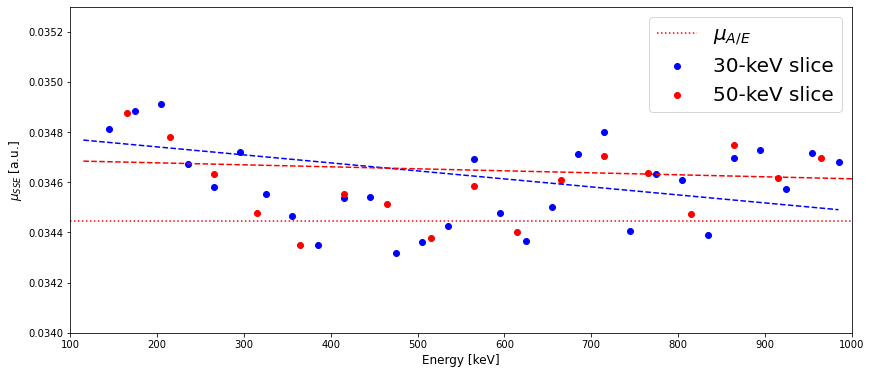

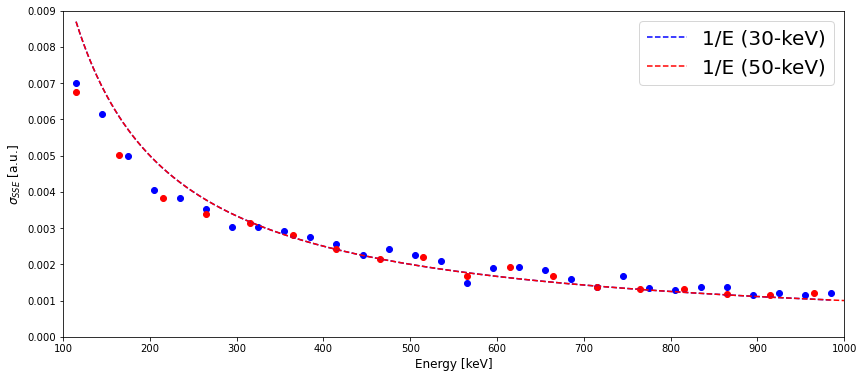

In [34]:


fig = plt.figure(figsize=(14,6))
coef = np.polyfit(xticks,meanstot,1)
poly1d_fn = np.poly1d(coef) 
plt.scatter(xticks,meanstot, marker='o',  color='b', label='30-keV slice')
plt.plot(xticks, poly1d_fn(xticks), '--b') #, label='linear fit')

coef2 = np.polyfit(xticks2,meanstot2,1)
poly1d_fn2 = np.poly1d(coef2) 
plt.scatter(xticks2,meanstot2, marker='o',  color='r', label='50-keV slice' )
plt.plot(xticks2, poly1d_fn2(xticks2), '--r')

plt.ylim(0.034,0.0353)
plt.ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.xlim(100,1000)
plt.xticks(np.arange(100,1100,100))
plt.axhline(0.03444373720763273, linestyle=':', color='r', label='$\u03BC_{A/E}$')
plt.legend(prop={'size': 20})


plt.savefig('new_plots/ICmean(run113)(115)(%.2e)-(%.f)vs50keV.pdf'%(coef[0],w))

print(coef)
print(coef2)

#print(binw, '-----', n)

stdtot =  [abs(ele) for ele in stdtot]
stdtot2 =  [abs(ele) for ele in stdtot2]

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks, stdtot, marker='o', color='b')
plt.scatter(xticks2, stdtot2, marker='o', color='r') 

E = np.arange(min(xticks), max(xticks), 1)
ss = 1/E

E2 = np.arange(min(xticks2), max(xticks2), 1)
ss2 = 1/E2


plt.plot(E,ss, color='b', linestyle='--', label = '1/E (30-keV)')
plt.plot(E2,ss2, color='r', linestyle='--', label = '1/E (50-keV)')

plt.ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.xlim(100,1000)
plt.ylim(0.0,0.009)
plt.xticks(np.arange(100,1100,100))
plt.legend(prop={'size': 20})
plt.savefig('new_plots/ICsigma(run113)(115)(%.2e)(%.f)vs50keV.pdf'%(coef[0],w))

#binw = 0.0001, 0.0007

[-3.18954294e-07  3.48048114e-02]
[-7.94760270e-08  3.46933602e-02]


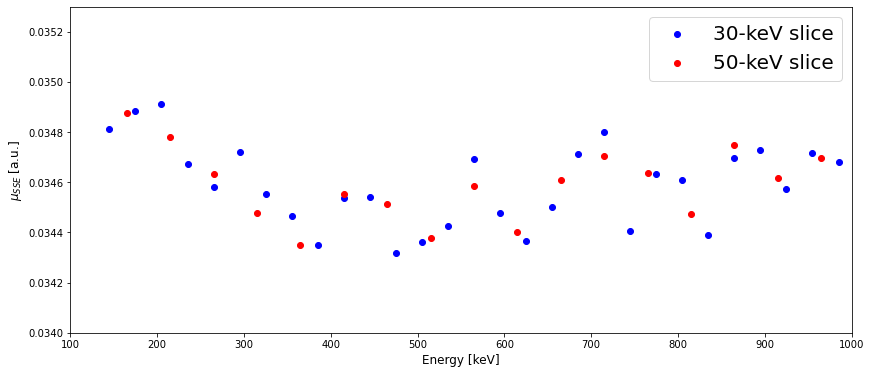

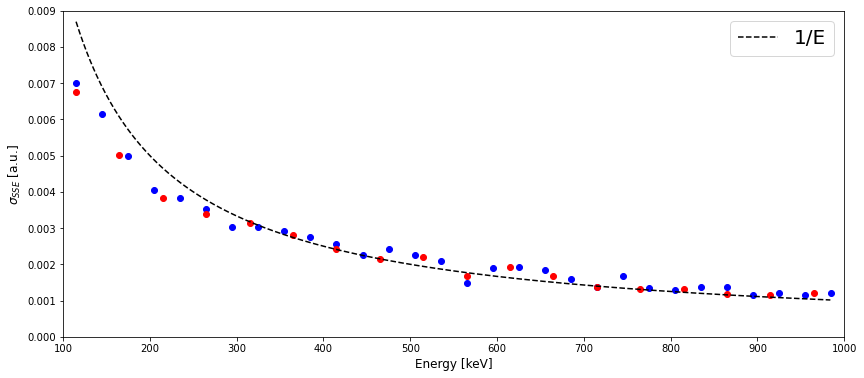

In [2]:


fig = plt.figure(figsize=(14,6))
coef = np.polyfit(xticks,meanstot,1)
poly1d_fn = np.poly1d(coef) 
plt.scatter(xticks,meanstot, marker='o',  color='b', label='30-keV slice')
# plt.plot(xticks, poly1d_fn(xticks), '--b', label='30-keV slice') #, label='linear fit')

coef2 = np.polyfit(xticks2,meanstot2,1)
poly1d_fn2 = np.poly1d(coef2) 
plt.scatter(xticks2,meanstot2, marker='o',  color='r', label='50-keV slice' )
# plt.plot(xticks2, poly1d_fn2(xticks2), '--r', label='50-keV slice')

plt.ylim(0.034,0.0353)
plt.ylabel('$\u03BC_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.xlim(100,1000)
plt.xticks(np.arange(100,1100,100))
# plt.axhline(0.03444373720763273, linestyle=':', color='r', label='$\u03BC_{A/E}$')
plt.legend(prop={'size': 20})


plt.savefig('new_plots/ICmean(run113)(115)(%.2e)-(%.f)vs50keV-edited.pdf'%(coef[0],w))

print(coef)
print(coef2)

#print(binw, '-----', n)

stdtot =  [abs(ele) for ele in stdtot]
stdtot2 =  [abs(ele) for ele in stdtot2]

fig = plt.figure(figsize=(14,6))
plt.scatter(xticks, stdtot, marker='o', color='b')
plt.scatter(xticks2, stdtot2, marker='o', color='r') 

E = np.arange(min(xticks), max(xticks), 1)
ss = 1/E

E2 = np.arange(min(xticks2), max(xticks2), 1)
ss2 = 1/E2


plt.plot(E,ss, color='k', linestyle='--', label = '1/E')
# plt.plot(E2,ss2, color='r', linestyle='--', label = '1/E (50-keV)')

plt.ylabel('$\u03C3_{SSE}$ [a.u.]', fontsize=12)
plt.xlabel('Energy [keV]', fontsize=12)
plt.xlim(100,1000)
plt.ylim(0.0,0.009)
plt.xticks(np.arange(100,1100,100))
plt.legend(prop={'size': 20})
plt.savefig('new_plots/ICsigma(run113)(115)(%.2e)(%.f)vs50keV-edited.pdf'%(coef[0],w))

#binw = 0.0001, 0.0007